In [ ]:
import kagglehub

kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:
download_path = kagglehub.competition_download("dogs-vs-cats")

100%|██████████| 812M/812M [00:20<00:00, 40.9MB/s]

Extracting files...


In [ ]:
!unzip -qq dogs-vs-cats.zip

unzip:  cannot find or open dogs-vs-cats.zip, dogs-vs-cats.zip.zip or dogs-vs-cats.zip.ZIP.


In [ ]:
import zipfile

with zipfile.ZipFile(download_path + "/train.zip", "r") as zip_ref:
    zip_ref.extractall("train")

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train/train")
new_base_dir = pathlib.Path("dogs_vs_cats_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

In [ ]:
import keras
from keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary(line_length=80)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)          │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ rescaling (Rescaling)             │ (None, 180, 180, 3)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d (Conv2D)                   │ (None, 178, 178, 32)     │           896 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)      │ (None, 89, 89, 32)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)                 │ (None, 87, 87, 64)       │        18,496 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)    │ (None, 43, 43, 64)       │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)                 │ (None, 41, 41, 128)      │        73,856 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)    │ (None, 20, 20, 128)      │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)                 │ (None, 18, 18, 256)      │       295,168 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)    │ (None, 9, 9, 256)        │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)                 │ (None, 7, 7, 512)        │     1,180,160 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ global_average_pooling2d          │ (None, 512)              │             0 │
│ (GlobalAveragePooling2D)          │                          │               │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense (Dense)                     │ (None, 1)                │           513 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 1,569,089 (5.99 MB)

 Trainable params: 1,569,089 (5.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
from keras.utils import image_dataset_from_directory

batch_size = 64
image_size = (180, 180)
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=image_size,
    batch_size=batch_size)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=image_size,
    batch_size=batch_size)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=image_size,
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (64, 180, 180, 3)
labels batch shape: (64,)


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 324ms/step - accuracy: 0.5157 - loss: 0.7260 - val_accuracy: 0.5980 - val_loss: 0.6916
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.5423 - loss: 0.6921 - val_accuracy: 0.5470 - val_loss: 0.6848
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5762 - loss: 0.6825 - val_accuracy: 0.6270 - val_loss: 0.6598
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.6158 - loss: 0.6566 - val_accuracy: 0.6180 - val_loss: 0.6589
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.5544 - loss: 0.6788 - val_accuracy: 0.6370 - val_loss: 0.6302
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.6331 - loss: 0.6349 - val_accuracy: 0.6420 - val_loss: 0.6317
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.6459 - loss: 0.6331 - val_accuracy: 0.6770 - val_loss: 0.5962
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.6782 - loss: 0.6043 - val_accuracy: 0

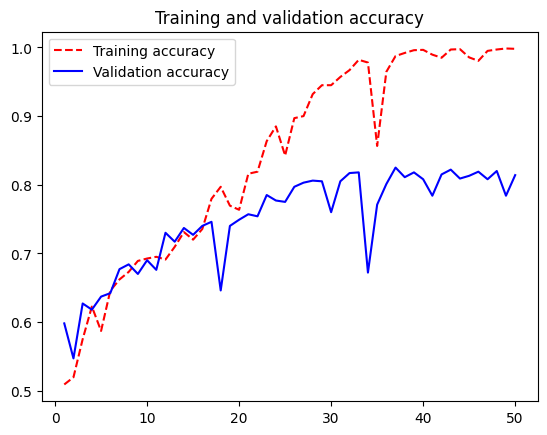

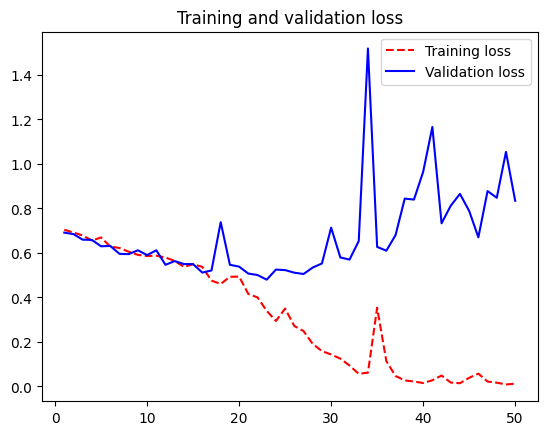

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8013 - loss: 0.4963
Test Accuracy: 0.807


1. The Test Accuracy was 0.807 for me
2. The Total Parameters was 1,569,089
3. The Total Time to train my model was around 4 minutes. I do not think it took that long to train really.

In [ ]:
import tensorflow as tf

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
]
def data_augmentation(images, targets):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, targets

augmented_train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=8)
augmented_train_dataset = augmented_train_dataset.prefetch(tf.data.AUTOTUNE)

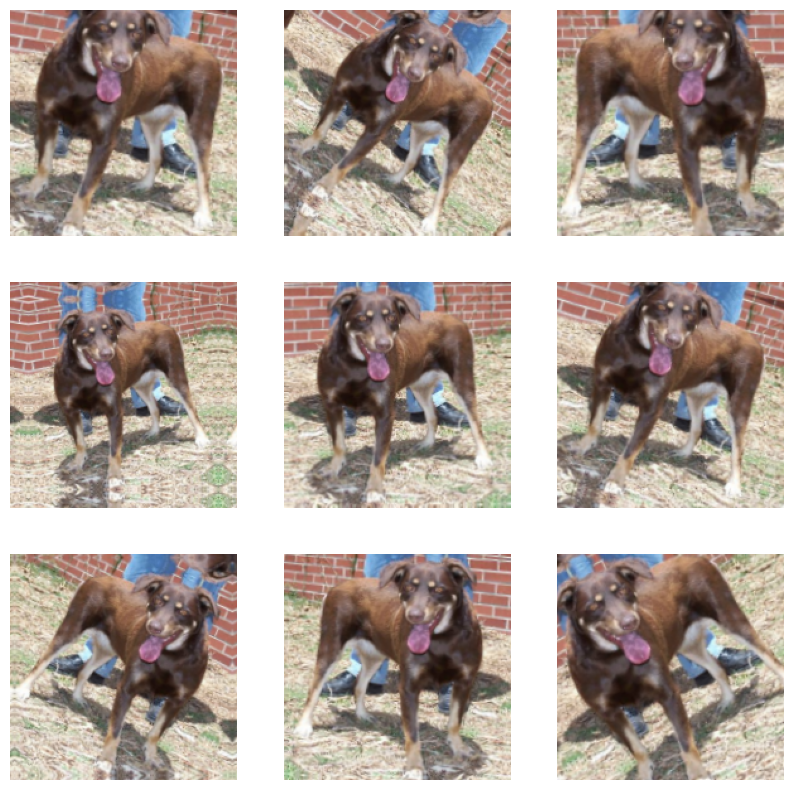

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

plt.figure(figsize=(10, 10))
for image_batch, _ in train_dataset.take(1):
    image = image_batch[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image, _ = data_augmentation(image, None)
        plt.imshow(np.array(augmented_image).astype("uint8"))
        plt.axis("off")

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    augmented_train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 468ms/step - accuracy: 0.5166 - loss: 0.6940 - val_accuracy: 0.5240 - val_loss: 0.6904
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 412ms/step - accuracy: 0.5576 - loss: 0.6904 - val_accuracy: 0.5000 - val_loss: 0.7701
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.5102 - loss: 0.7056 - val_accuracy: 0.5620 - val_loss: 0.6901
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 439ms/step - accuracy: 0.4914 - loss: 0.6894 - val_accuracy: 0.5960 - val_loss: 0.6829
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 415ms/step - accuracy: 0.5458 - loss: 0.6818 - val_accuracy: 0.6090 - val_loss: 0.6695
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.5871 - loss: 0.6751 - val_accuracy: 0.5580 - val_loss: 0.7108
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 413ms/step - accuracy: 0.6368 - loss: 0.6343 - val_accuracy: 0.5780 - val_loss: 0.6559
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 355ms/step - accuracy: 0.6334 - loss: 0.6390 - 

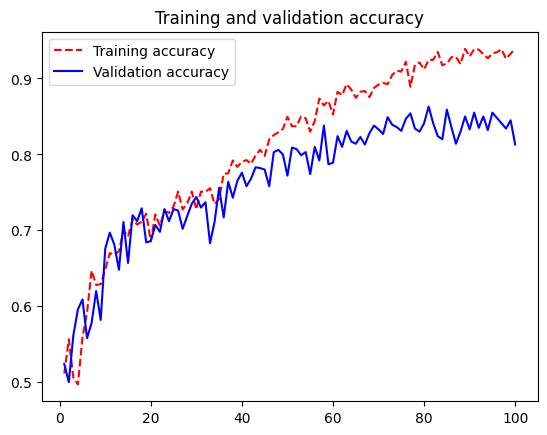

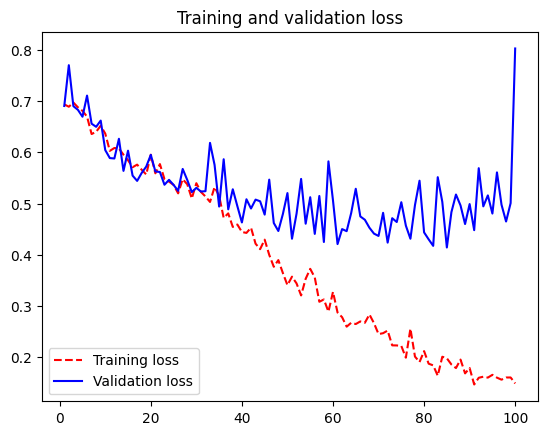

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.3f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.8563 - loss: 0.4349
Test Accuracy: 0.854


1. The Test Accuracy was 0.854, and this one took an absurd amount of time compared to the others. The timer has it at 27 minutes.
